In [1]:
import fasttext
import numpy as np
import pandas as pd
from typing import List
from tqdm.auto import tqdm
from stop_words import get_stop_words

from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

from catboost import CatBoostRegressor

In [2]:
import sys
import os

# Добавляем корень проекта в путь
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.utils import save_predictions_to_file, create_predictions_df

from src.experiments import run_experiment, make_predictions

In [3]:
# Загрузка предобученной модели FastText
print("Загрузка модели FastText...")
fasttext_cc_ru_300 = fasttext.load_model("../cc.ru.300.bin")

Загрузка модели FastText...


In [4]:
def read_csv_with_progress(file_path, nrows, chunk_size=10_000):
    chunks = []
    if nrows is not None:
        total_rows = nrows
    else:
        try:
            total_rows = sum(1 for _ in open(file_path, 'r', encoding='utf-8')) - 1 # Subtract 1 for header
        except UnicodeDecodeError:
            total_rows = sum(1 for _ in open(file_path, 'r', encoding='latin1')) - 1 # Try different encoding if needed

    print(f"Reading CSV file in chunks of {chunk_size} rows...")
    chunk_loader = tqdm(
        iterable=pd.read_csv(
            filepath_or_buffer=file_path,
            chunksize=chunk_size,
            nrows=nrows
        ),
        total=(total_rows // chunk_size)
    )
    for chunk in chunk_loader:
        chunks.append(chunk)
    
    df = pd.concat(chunks, axis=0)
    return df


In [5]:
import re
import string
from typing import List, Optional

class TextPreprocessor:
    def __init__(
        self,
        stop_words: Optional[List[str]] = None,
    ) -> None:
        self.stop_words = stop_words

    def preprocess(
        self,
        text: str,
        remove_html: bool = True,
        remove_urls: bool = True,
        remove_emails: bool = True,
        remove_punctuation: bool = True,
        lower_case: bool = True,
        remove_extra_spaces: bool = True,
        lemmatize: bool = False
    ) -> str:
        if not isinstance(text, str):
            return ""

        if lower_case:
            text = text.lower()

        if remove_html:
            text = re.sub(r'<[^>]+>', '', text)

        if remove_urls:
            text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

        if remove_emails:
            text = re.sub(r'\S+@\S+', '', text)

        if remove_punctuation:
            text = text.translate(str.maketrans('', '', string.punctuation))

        if remove_extra_spaces:
            text = re.sub(r'\s+', ' ', text).strip()

        if self.stop_words:
            tokens = text.split()
            tokens = [token for token in tokens if token not in self.stop_words]
            text = ' '.join(tokens)

        return text

In [ ]:
def text_to_vector(
    text: str,
    vectorizer,
    normalize=True
) -> np.ndarray:
    words = text.lower().split()

    word_vectors = [vectorizer.get_word_vector(w) for w in words if w.strip()]
    
    if not word_vectors:
        return np.zeros(vectorizer.get_dimension())
    
    vec = np.mean(word_vectors, axis=0)
    
    if normalize:
        norm = np.linalg.norm(vec)
        if norm > 0:
            vec = vec / norm
    
    return vec

In [ ]:
def preprocess_and_vectorize_texts(
    texts: List[str],
    preprocessor,
    vectorizer,
) -> np.ndarray:
    text_embeddings = []
    text_loader = tqdm(
        iterable=texts,
        desc="Векторизация текстов"
    )
    for text in text_loader:
        preprocessed_text = preprocessor.preprocess(
            text=text,
            lemmatize=True,
        )

        emb = text_to_vector(
            text=preprocessed_text,
            vectorizer=vectorizer,
            normalize=True,
        )

        text_embeddings.append(emb)

    return np.array(text_embeddings)

In [8]:
nrows = None # To read all data: nrows = None

train_dataset = read_csv_with_progress(
    file_path="../data/train_val/geo_reviews_2023.csv",
    nrows=nrows,
)

Reading CSV file in chunks of 10000 rows...


  0%|          | 0/50 [00:00<?, ?it/s]

In [9]:
stop_words = set(get_stop_words("russian"))
preprocessor = TextPreprocessor(
    stop_words=stop_words,
)

X = preprocess_and_vectorize_texts(
    texts=train_dataset["text"],
    preprocessor=preprocessor,
    vectorizer=fasttext_cc_ru_300,
)
y = train_dataset["rating"]

Векторизация текстов:   0%|          | 0/500000 [00:00<?, ?it/s]

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.01,
    random_state=42,
    stratify=y,
)

print("train shape:", X_train.shape)
print("test shape:", X_test.shape)

train shape: (495000, 300)
test shape: (5000, 300)


In [22]:
model = CatBoostRegressor(
    iterations=2_000,
    eval_metric="RMSE",
    random_seed=42,
    verbose=True,
)

model.fit(
    X=X_train,
    y=y_train,
    eval_set=(X_test, y_test),
    logging_level="Verbose",
)

Learning rate set to 0.088373
0:	learn: 1.1168497	test: 1.1146962	best: 1.1146962 (0)	total: 74.6ms	remaining: 2m 29s
1:	learn: 1.0909951	test: 1.0876053	best: 1.0876053 (1)	total: 155ms	remaining: 2m 35s
2:	learn: 1.0673729	test: 1.0623573	best: 1.0623573 (2)	total: 236ms	remaining: 2m 36s
3:	learn: 1.0470954	test: 1.0407775	best: 1.0407775 (3)	total: 298ms	remaining: 2m 28s
4:	learn: 1.0287486	test: 1.0209114	best: 1.0209114 (4)	total: 364ms	remaining: 2m 25s
5:	learn: 1.0117070	test: 1.0025270	best: 1.0025270 (5)	total: 433ms	remaining: 2m 23s
6:	learn: 0.9960136	test: 0.9874424	best: 0.9874424 (6)	total: 508ms	remaining: 2m 24s
7:	learn: 0.9823929	test: 0.9725836	best: 0.9725836 (7)	total: 606ms	remaining: 2m 31s
8:	learn: 0.9700541	test: 0.9593271	best: 0.9593271 (8)	total: 684ms	remaining: 2m 31s
9:	learn: 0.9587361	test: 0.9475331	best: 0.9475331 (9)	total: 755ms	remaining: 2m 30s
10:	learn: 0.9484022	test: 0.9353251	best: 0.9353251 (10)	total: 834ms	remaining: 2m 30s
11:	learn:

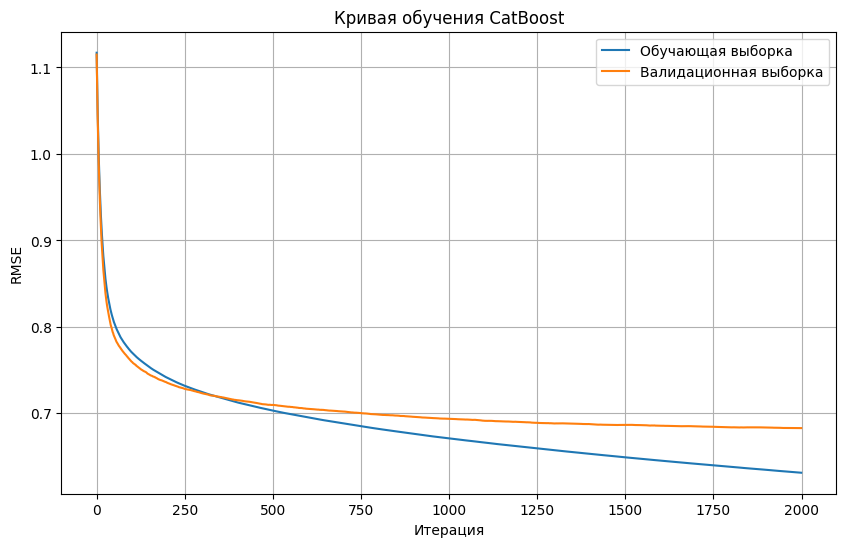

In [23]:
import matplotlib.pyplot as plt

results = model.get_evals_result()

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(results['learn']['RMSE'], label='Обучающая выборка')
plt.plot(results['validation']['RMSE'], label='Валидационная выборка')
plt.xlabel('Итерация')
plt.ylabel('RMSE')
plt.title('Кривая обучения CatBoost')
plt.legend()
plt.grid()
plt.show()

In [34]:
# === 5. Предсказания ===
y_pred = model.predict(X_test)
RMSE = root_mean_squared_error(y_test, y_pred)
print(f"RMSE: {RMSE:.3f}")

RMSE: 0.683


In [46]:
errors = np.abs(y_pred - y_test)

# sorted_errors = sorted(errors)

# print(sorted_errors)

In [25]:
test_dataset = read_csv_with_progress(
    file_path="../data/test/test.csv",
    nrows=None,
)

Reading CSV file in chunks of 10000 rows...


0it [00:00, ?it/s]

In [26]:
X_test = preprocess_and_vectorize_texts(
    texts=test_dataset["review_text"],
    preprocessor=preprocessor,
    vectorizer=fasttext_cc_ru_300,
)

Векторизация текстов:   0%|          | 0/5069 [00:00<?, ?it/s]

In [27]:
# === 5. Предсказания ===
y_pred = model.predict(X_test)

y_pred = np.clip(a=y_pred, a_min=1.0, a_max=5.0)

predictions_df = create_predictions_df(predicted_rating=y_pred)

display(predictions_df)

,id,predicted_rating
0,0,3.376363
1,1,5.000000
2,2,1.166989
3,3,1.973528
4,4,4.901123
...,...,...
5064,5064,2.481905
5065,5065,4.353825
5066,5066,2.118154
5067,5067,3.266885


In [30]:
save_predictions_to_file(y_pred=y_pred, title="fasttext_catboost")